# Get GPS

In [1]:
import pandas as pd
from datalabeling.common.annotation_utils import GPSUtils
from pathlib import Path
from itertools import chain

d:\datalabeling\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def get_gps_coords(image_dir:str,
                   image_paths:list[str]=None,
                   exts:list[str] = ['*.jpg','*.jpeg','*.png',]):

    exts = [e.lower() for e in exts] + [e.capitalize() for e in exts]

    if image_paths is None:
        image_paths = chain.from_iterable([Path(image_dir).glob(ext) for ext in exts])

    gps_coords = [GPSUtils.get_gps_coord(file_name=path,return_as_decimal=True)[0] for path in image_paths]
    
    gps_coords = pd.DataFrame(data=gps_coords,
                 columns=["Latitude", "Longitude", "Elevation"])
    
    return gps_coords

In [4]:
extracted_exif = GPSUtils.get_exif(r"D:\savmap_dataset_v2\raw\images\0aff71b5a50d4357bfcca7cf5f614b7d.JPG")

gps_info = GPSUtils.get_gps_info(extracted_exif)

gps_info

{'GPSVersionID': [2, 3, 0, 0],
 'GPSLatitudeRef': 'S',
 'GPSLatitude': (23.0, 12.0, 38.622960045019695),
 'GPSLongitudeRef': 'E',
 'GPSLongitude': (18.0, 21.0, 29.31192005710207),
 'GPSAltitude': '1496.6827309236949',
 'GPSTrack': 79.89536266349585}

In [ ]:
df_gps = get_gps_coords(image_dir=r"D:\savmap_dataset_v2\raw\images",
                        image_paths=None)

In [6]:
df_gps

,Latitude,Longitude,Elevation
0,-23.185786,18.380313,1489.539400
1,-23.184062,18.376709,1486.842700
2,-23.215928,18.360828,1496.319588
3,-23.215876,18.355488,1495.295409
4,-23.221646,18.395676,1480.894410
...,...,...,...
1303,-23.215110,18.430430,1478.588015
1304,-23.193977,18.384050,1461.046392
1305,-23.181181,18.380090,1488.729800
1306,-23.209417,18.430249,1479.213622


# Get parent image from sliced image

In [ ]:
import math, os
from itertools import product
import torchvision, PIL

def get_coordinates(img_path:str,tile_w:int,tile_h:int,overlaping_factor:float):
    
    pil_img = PIL.Image.open(img_path)
    img_tensor = torchvision.transforms.ToTensor()(pil_img)

    image_width=img_tensor.shape[2]
    image_height=img_tensor.shape[1]

    # x limits
    lim = math.ceil((image_width-tile_w)/((1-overlaping_factor)*tile_w))
    x_right = [math.floor(tile_w + i*(1-overlaping_factor)*tile_w) for i in range(lim)]
    x_coords = [(x-tile_w,x) for x in x_right]
    if len(x_coords)>0:
        left,right = x_coords[-1]
        x_coords[-1] = (left,image_width) # extending to remaining pixels

    # y limits
    lim = math.ceil((image_height-tile_h)/((1-overlaping_factor)*tile_h))
    y_bottom = [math.floor(tile_h + i*(1-overlaping_factor)*tile_h) for i in range(lim)]
    y_coords = [(y-tile_h,y) for y in y_bottom]
    if len(y_coords)>0:
        top,bottom = y_coords[-1]
        y_coords[-1] = (top,image_height) # extending to remaining pixels

    # tiles coordinates
    if len(y_coords)>0 and len(x_coords)>0:
        pass
    elif len(y_coords) == 0:
        y_coords = [(0,image_height),]
    elif len(x_coords) == 0:
        x_coords = [(0,image_width),]

    coordinates = product(x_coords,y_coords)

    return list(coordinates)

def get_save_paths(
    batch:list,
    basename: str,
    dest_folder: str
    ) -> None:
    ''' Save mini-batch tensors into image files

    Use torchvision save_image function,
    see https://pytorch.org/vision/stable/utils.html#torchvision.utils.save_image

    Args:
        batch (list): mini-batch tensor
        basename (str) : parent image name, with extension
        dest_folder (str): destination folder path
    '''
    paths = list()
    base_wo_extension, extension = basename.split('.')[0], basename.split('.')[1]
    for i, b in enumerate(range(len(batch))):
        full_path = '_'.join([base_wo_extension, str(i) + '.']) + extension
        save_path = os.path.join(dest_folder, full_path)

        get_save_paths.append(save_path)
    
    return 

In [ ]:
coords =  get_coordinates(img_path:str,tile_w=2000,tile_h=2000,overlaping_factor=0.1)

# Image tiling for annotation

#### Meanings of arguments
- ```-ratioheight``` : proportion of tile  w.r.t height of image. Example 0.5 means dividing the image in two bands w.r.t height.
- ```-ratiowidth``` : proportion of tile w.r.t to width of image. Example 1.0 means the width of the tile is the same as the image.
- ```-overlapfactor``` : percentage of overlap. It should be less than 1.
- ```-rmheight``` : percentage of height to remove or crop at bottom and top
- ```-rmwidth``` : percentage of width to remove or crop on each side of the image
- ```-pattern``` : "**/*.JPG" will get all .JPG images in directory and subdirectories. On windows it will get both .JPG and .jpg. On unix it will only get .JPG images


In [ ]:
# New script for tiling data
# images_to_tile = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images"
# destination_directory = r"D:\PhD\Data per camp\Extra training data\savmap_dataset_v2\raw_data\images-tiled"
!python ../../HerdNet/tools/patcher.py "D:\PhD\Harvard data\Satara_east\Selection" 0 0 0 -overlapfactor 0.1  -ratiowidth 0.5 -ratioheight 0.5 -rmheight 0.1 -rmwidth 0.1 -dest "D:\PhD\Harvard data\Satara_east\Selection - tiled" -pattern "**/*.JPG"

# Pre-annotating data for Labelstudio

In [ ]:
from dotenv import load_dotenv
load_dotenv('../.env')

from datalabeling.ml import Annotator
import os
from pathlib import Path
import torch
from tqdm import tqdm

### Creating a JSON file to be uuploaded to Label studio

In [ ]:
# DEPRECATED
# provide correct alias, "pt", "onnx"
# alias = "last" # the aliases are found in mlflow tracker UI, use "last-1" to use the previous model
# name = "obb-detector" # detector, "obb-detector"
# handler = Annotator(mlflow_model_alias=alias,
#                     mlflow_model_name=name,
#                     is_yolo_obb= name.strip() == "obb-detector",
#                     # dotenv_path="../.env"
#                     )
# path_img_dir=r"D:\PhD\Africa Parks\Liuwa aerial survey_ALL\CENSUS 2019\DAY 2 CENSUS 2019_CONVERTED\AP 2019 day 2 - tiled"
# root="D:\\"
# save_json_path = os.path.join(Path(path_img_dir).parent, f"{Path(path_img_dir).name}_preannotation_label-studio.json")

# # build and saves json
# directory_preds = handler.build_upload_json(path_img_dir=path_img_dir,
#                                             root=root,
#                                             save_json_path=save_json_path,
#                                             pattern="**/*.JPG")

### Pre-annotating an existing project using Label studio API
It seems that it will not work well (i.e. filtering) with older projects created prior to Label studio software update.
It is the **recommended way of pre-annotating data in Labelstudio**.

In [ ]:
# provide correct alias, "pt", "onnx"
aliases = ["yolov12s",]
project_id = 96 # insert correct project_id by loooking at the url
for alias in aliases:
    name = "detector" # detector, "obb-detector"
    handler = Annotator(mlflow_model_alias=alias,
                        mlflow_model_name=name,
                        confidence_threshold=0.15,
                        is_yolo_obb=name.strip() == "obb-detector",
                        dotenv_path="../.env")
    handler.upload_predictions(project_id=project_id)

**Before running the script below, make sure you have exported the annotations so you CAN revert back!!!**
- CLEANING ANNOTATIONS that have been mistakenly saved with label="wildlife"

In [ ]:
#  Cleaning annotations - NO WAY BACK
name = "obb-detector"
handler = Annotator(mlflow_model_alias="version6",
                        mlflow_model_name=name,
                        confidence_threshold=0.25,
                        is_yolo_obb=name.strip() == "obb-detector",
                        dotenv_path="../.env")

# Select project
project_id = 88
project = handler.labelstudio_client.get_project(id=project_id)

# Delete annotations saved with label "wildlife" assigned by the predictor
tasks = project.get_tasks()
for task in tqdm(tasks,desc="correcting annotations"):
        task_id = task['id']
        img_url = task['data']['image']

        if len(task["annotations"][0]['result'])>1:
            results_to_keep = []
            annot_id = task["annotations"][0]["id"]
            for annot in task['annotations'][0]['result']:
                if annot['value']['rectanglelabels'][0] != 'wildlife':
                    results_to_keep.append(annot)
                    # print(annot['value'],annot['id'],end="\n")
            # print(f"Updating annotations {annot_id} from task {task_id}.")
            # print(results_to_keep)
            project.update_annotation(annot_id,result=results_to_keep)

In [ ]:
len(task['annotations']), len(task['annotations'][0]['result']), task['id'], task["annotations"][0]["id"]

In [ ]:
task['annotations'][0]['result'][0] #['value']['rectanglelabels']

In [ ]:
results_to_keep = []
for annot in task['annotations'][0]['result']:
    if annot['value']['rectanglelabels'][0] != 'wildlife':
        results_to_keep.append(annot)
        print(annot['value'],annot['id'],end="\n")

In [ ]:
results_to_keep

In [ ]:
project.update_annotation(annotation_id=...,)

To speed up inference on intel, make changes inn ultralytics/nn/autobackend.py:
```
- device_name = "AUTO:NPU,GPU,CPU" # CPU, GPU, NPU, AUTO,"AUTO:GPU,NPU"
- inference_mode = "LATENCY" # OpenVINO inference modes are 'LATENCY', 'THROUGHPUT' (not recommended), or 'CUMULATIVE_THROUGHPUT'
- LOGGER.info(f"Using OpenVINO {inference_mode} mode for inference...")
- ov_compiled_model = core.compile_model(
                ov_model,
                device_name=device_name,  # AUTO selects best available device, do not modify
                config={"PERFORMANCE_HINT": inference_mode,
                        "CACHE_DIR": os.environ["OPENVINO_CACHE_MODEL"]}, # make sure to set environment variable
            )
```

In [ ]:
# using path_to_weights
# go to ultralytics.nn.autobackend to modify ov_compiled device to "AUTO:NPU,GPU,CPU"

use_sliding_window=True

handler = Annotator(path_to_weights=r"D:\datalabeling\base_models_weights\best.pt",
                    is_yolo_obb=True,
                    tilesize=640,
                    overlapratio=0.1,
                    use_sliding_window=use_sliding_window,
                    confidence_threshold=0.5,
                    # device="NPU", # "cpu", "cuda"
                    tag_to_append=f"-sahi:{use_sliding_window}",
                    dotenv_path="../.env")

project_id = 3 # insert correct project_id by loooking at the url
top_n=10
handler.upload_predictions(project_id=project_id,top_n=top_n)

In [ ]:
from label_studio_ml.utils import get_local_path
from urllib.parse import unquote
path = unquote("/data/local-files/?d=savmap_dataset_v2%5Cimages_splits%5C003a34ee6b7841e6851b8fe511ebe102_0.JPG")
get_local_path(path,download_resources=False)#,os.path.exists(get_local_path(path))

# Inference

In [56]:
from ultralytics import YOLO
from PIL import Image
import time
import numpy as np
from datalabeling.ml import Detector, Annotator
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
import pandas as pd
from itertools import chain


In [2]:
# load env variable, loads model cache location!!
load_dotenv('../.env')

True

## Standard Inference

In [4]:
# provide correct alias, "pt", "onnx"
alias = "yolov11x-obb"
project_id = 96 # insert correct project_id by loooking at the url

dotenv_path="../.env"

name = "obb-detector" # detector, "obb-detector"

handler = Annotator(mlflow_model_alias=alias,
                    mlflow_model_name=name,
                    confidence_threshold=0.15,
                    is_yolo_obb=name.strip() == "obb-detector",
                    dotenv_path=dotenv_path)


05/09/2025 12:01:44 - INFO - datalabeling.ml.models -   Computing device: cuda:0


In [57]:
handler = Detector(path_to_weights=r"C:/Users/Machine Learning/Desktop/workspace-wildAI/datalabeling/runs/mlflow/140168774036374062/f5b7124be14c4c89b8edd26bcf7a9a76/artifacts/weights/best.pt",
                   imgsz=960,
                   tilesize=960,
                   confidence_threshold=0.25,
                   use_sliding_window=True)

05/09/2025 14:04:35 - INFO - datalabeling.ml.models -   Computing device: cuda


In [59]:
image_dir = r"D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-8\Rep 1"
save_path = Path(image_dir).parent / "detection_gps.csv"

exts = [
        "*.jpg",
        "*.jpeg",
        "*.png",
    ]
exts = [e.lower() for e in exts] + [e.capitalize() for e in exts]

image_paths = chain.from_iterable([Path(image_dir).glob(ext) for ext in exts])

image_paths = list(Path(image_dir).glob('*.jpg'))[:9]
len(image_paths)

9

In [60]:
results = handler.predict_directory(
        path_to_dir = None,
        images_paths = image_paths,
        return_gps = True,
        return_coco = False,
        as_dataframe = True,
        save_path = None,
    )

pred results as df: 100%|██████████| 94/94 [00:00<00:00, 2764.54it/s]


In [63]:
results.head()

,score,category_id,category_name,area,file_name,x_min,y_min,bbox_w,bbox_h,x_max,y_max,gps,Latitude,Longitude,Elevation,px_Latitude,px_Longitude
0,0.883107,0,wildlife,4389,D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-...,2378.009277,1579.267395,79.137451,62.371948,2457.146729,1641.639343,23.0 56.0m 56.524s S 30.0 33.0m 8.8846s E 830....,-23.949034,30.552468,830.694,-23.948800,30.552100
1,0.857370,0,wildlife,4049,D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-...,2396.050964,870.193237,61.375610,67.708618,2457.426575,937.901855,23.0 56.0m 56.524s S 30.0 33.0m 8.8846s E 830....,-23.949034,30.552468,830.694,-23.948656,30.552104
2,0.855882,0,wildlife,4732,D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-...,2133.558807,2115.529785,93.452026,60.395996,2227.010834,2175.925781,23.0 56.0m 56.524s S 30.0 33.0m 8.8846s E 830....,-23.949034,30.552468,830.694,-23.948908,30.552045
3,0.855088,0,wildlife,4128,D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-...,2614.296637,1226.002075,63.287691,66.551514,2677.584328,1292.553589,23.0 56.0m 56.524s S 30.0 33.0m 8.8846s E 830....,-23.949034,30.552468,830.694,-23.948729,30.552152
4,0.852219,0,wildlife,3220,D:\PhD\Data per camp\Dry season\Kapiri\Camp 6-...,2387.762024,1427.064575,80.992432,43.456421,2468.754456,1470.520996,23.0 56.0m 56.524s S 30.0 33.0m 8.8846s E 830....,-23.949034,30.552468,830.694,-23.948767,30.552103


In [64]:
results['file_name'].unique().shape

(6,)

In [39]:
# results = pd.read_csv(r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\.tmp\detections.csv")

# results.head()

In [52]:
# loaded_results = pd.read_csv(r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\.tmp\detections.csv")

# print(loaded_results.head())

# # folium map
# m = folium.Map(location=[loaded_results.Latitude.mean(), loaded_results.Longitude.mean()], zoom_start=13)

# folium.TileLayer('Esri.WorldImagery', name='Esri Satellite', control=True).add_to(m)

# marker_cluster = MarkerCluster().add_to(m)

# for idx, row in loaded_results.iterrows():
#     folium.Marker(
#         location=[row.Latitude, row.Longitude],
#         popup=row.name
#     ).add_to(marker_cluster)

# m.save('.tmp/cluster_map_2.html')

<Axes: xlabel='Latitude', ylabel='Longitude'>

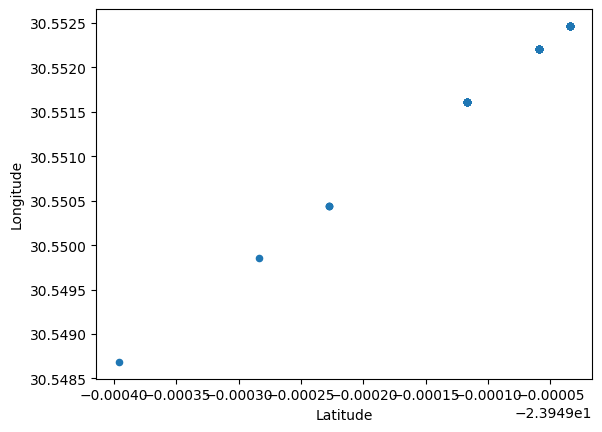

In [66]:
results.plot(kind='scatter',x='Latitude',y='Longitude')

In [68]:
# folium map

m = folium.Map(location=[results.Latitude.mean(), results.Longitude.mean()], zoom_start=13)

folium.TileLayer('Esri.WorldImagery', name='Esri Satellite', control=True).add_to(m)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in results.iterrows():
    folium.Marker(
        location=[row.Latitude, row.Longitude],
        popup=row.name
    ).add_to(marker_cluster)

m.save('.tmp/cluster_map.html')



In [ ]:
# results[['Latitude', 'Longitude', 'Elevation']].to_csv(save_path,index=False)

## Optimizing with Openvino

To speed up inference on intel, make changes inn ultralytics/nn/autobackend.py:
```
- device_name = "AUTO:NPU,GPU,CPU" # CPU, GPU, NPU, AUTO,"AUTO:GPU,NPU"
- inference_mode = "LATENCY" # OpenVINO inference modes are 'LATENCY', 'THROUGHPUT' (not recommended), or 'CUMULATIVE_THROUGHPUT'
- LOGGER.info(f"Using OpenVINO {inference_mode} mode for inference...")
- ov_compiled_model = core.compile_model(
                ov_model,
                device_name=device_name,  # AUTO selects best available device, do not modify
                config={"PERFORMANCE_HINT": inference_mode,
                        "CACHE_DIR": os.environ["OPENVINO_CACHE_MODEL"]}, # make sure to set environment variable
            )
```

In [ ]:
IMAGE_PATH = r"D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_1.JPG"

In [ ]:
# Define detector
# to speed up inference on intel, make
model = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
                confidence_threshold=0.1,
                overlap_ratio=0.1,
                tilesize=1280,
                device='CPU',
                use_sliding_window=False,
                is_yolo_obb=True)

In [ ]:
image = Image.open(IMAGE_PATH)

while True:
    start_time = time.perf_counter()
    print(model.predict(image,return_coco=True,nms_iou=0.5))
    end_time = time.perf_counter()
    print(f"Device took {end_time-start_time:.2f} seconds.")

    break

In [ ]:
# inference with openvino
import openvino as ov
import openvino.properties.hint as hints
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.converter import coco80_to_coco91_class

# load validator
args = get_cfg(cfg=DEFAULT_CFG)
det_model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt")
det_validator = det_model.task_map[det_model.task]["validator"](args=args)
det_validator.is_coco = True
det_validator.class_map = coco80_to_coco91_class()
det_validator.names = det_model.model.names
det_validator.metrics.names = det_validator.names
det_validator.nc = det_model.model.model[-1].nc
det_validator.stride = 32
args = get_cfg(cfg=DEFAULT_CFG)
det_model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt")

core = ov.Core()
det_model_path = r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model\best.xml"
det_ov_model = core.read_model(det_model_path)

device = "AUTO:NPU,GPU" # CPU, NPU, GPU "AUTO:NPU,GPU,CPU" 

print("Available core devices: ",core.available_devices)

# reshaping for batch prediction
input_layer = det_ov_model.input(0)
output_layer = det_ov_model.output(0)
new_shape = ov.PartialShape([1, 3, 1280, 1280])
det_ov_model.reshape({input_layer.any_name: new_shape})

ov_config = {hints.performance_mode: hints.PerformanceMode.THROUGHPUT,
             "CACHE_DIR": '../models/model_cache'}

if ("GPU" in core.available_devices) and device=="GPU":
    ov_config["GPU_DISABLE_WINOGRAD_CONVOLUTION"] = "YES"
det_compiled_model = core.compile_model(det_ov_model, device, ov_config)

def infer(image):
    image = det_validator.preprocess({"img":image,"batch_idx":torch.Tensor([0]),
                                      "cls":torch.Tensor([0]),
                                      "bboxes":torch.Tensor([0.,0.,0.,0.])})["img"]
    results = det_compiled_model(image)
    preds = torch.from_numpy(results[det_compiled_model.output(0)])
    return det_validator.postprocess(preds) #torch.from_numpy(result[0])

In [ ]:
# image = Image.open(IMAGE_PATH)
# image = F.PILToTensor()(image)[None,:,:1280,:1280]
# infer(image)

In [ ]:
# inference with pt
# model = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best.pt",task='obb')

In [ ]:
# rescaling input images
# model(image/255.)

In [ ]:
# inference with openvino
# model_vino = YOLO(r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",task='obb')
# model_vino(image/255.)

In [ ]:
# sahi_model_obb = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
#                     confidence_threshold=0.6,
#                     overlap_ratio=0.1,
#                     tilesize=640,
#                     is_yolo_obb=True)

In [ ]:
# image_path = r"D:\savmap_dataset_v2\images\0d1ba3c424ad4414ac37dbd0c93460ea.JPG"
# image = Image.open(image_path)
# print(image.size)

In [ ]:
# result = sahi_model_obb.predict(image,False)

In [ ]:
# result
# result.export_visuals('../.tmp')

## Sahi inference calibration

In [ ]:
from itertools import product

In [ ]:
# hyperparams
overlap_ratios = [0.1,0.2,0.3]
tilesizes = [640,2*640,3*640]
imgsz = [640,2*640,3*640]

for ratio, tilesize, image_size in product(overlap_ratios,tilesizes,imgsz):
    print(ratio,tilesize,image_size)
    # Define detector
    # to speed up inference on intel, make
    model = Detector(path_to_weights=r"C:\Users\FADELCO\OneDrive\Bureau\datalabeling\models\best_openvino_model",
                    confidence_threshold=0.1,
                    overlap_ratio=0.1,
                    tilesize=2000,
                    imgsz=1280,
                    device='CPU',
                    use_sliding_window=True,
                    is_yolo_obb=True)
    
    #TODO


# YOLO data_config.yaml 

In [ ]:
import yaml
import json
from datalabeling.arguments import Arguments
import pandas as pd

In [ ]:
# load yaml
with open(r"D:\PhD\Data per camp\DetectionDataset\hard_samples\train_ratio_20-seed_41.yaml",'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)
yolo_config

In [ ]:
pd.read_csv(os.path.join(yolo_config["path"],yolo_config['train']),header=None,names=['paths'])['paths'].to_list()[:]

In [ ]:
# load label mapping
args = Arguments()
with open(r"D:\PhD\Data per camp\IdentificationDataset\label_mapping.json",'r') as file:
    label_map = json.load(file)
names = [p['name'] for p in label_map if p['name'] not in args.discard_labels ]
label_map = dict(zip(range(len(names)),names))
label_map

In [ ]:
from label_studio_sdk import Client
from dotenv import load_dotenv
load_dotenv('../.env')

def get_ls_parsed_config(ls_json_path:str):

    ls_client = None
    if ls_client is None:
        # Connect to the Label Studio API and check the connection
        LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
        API_KEY = os.getenv("LABEL_STUDIO_API_KEY")
        labelstudio_client = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

    with open(ls_json_path,'r') as f:
        ls_annotation = json.load(fp=f)
    ids = set([annot['project'] for annot in ls_annotation])
    assert len(ids)==1, "annotations come from different project. Not allowed!"
    project_id = ids.pop()
    project = labelstudio_client.get_project(id=project_id)

    return project.parsed_label_config


In [ ]:
yolo_config.update({'names':label_map,'nc':len(label_map)})
yolo_config

In [ ]:
with open(r"D:\PhD\Data per camp\IdentificationDataset\data_config.yaml",'w') as file:
    yaml.dump(yolo_config,file,default_flow_style=False, sort_keys=False)

# Dataset distribution

## Visualize distribution per annotation project

In [ ]:
from datalabeling.dataset import load_coco_annotations
import json
import pandas as pd
from collections import Counter
from dotenv import load_dotenv
# from itertools import chain
import traceback
import os
from pathlib import  Path

In [ ]:
dotenv_path=r"..\.env"
load_dotenv(dotenv_path=dotenv_path)
# Connect to the Label Studio API and check the connection
LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
API_KEY = os.getenv("LABEL_STUDIO_API_KEY")
labelstudio_client = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

In [ ]:

def get_project_stats(project_id:int,annotator_id = 0):
    
    project = labelstudio_client.get_project(id=project_id)
    num_images = dict()
    # Iterating 
    tasks = project.get_tasks()
     # because there is
    labels = []

    for task in tasks:
        try:
            result = task['annotations'][annotator_id]['result']
        except Exception:
            traceback.print_exc()
            continue

        img_labels = []
        for annot in result:
            img_labels = annot['value']['rectanglelabels'] + img_labels
        labels = labels + img_labels
        # update stats holder
        for label in set(img_labels):
            try:
                num_images[label] += 1
            except:
                num_images[label] = 1

    stats = {f"{k}":labels.count(k) for k in set(labels)}
    print("Number of instances for each label is:\n",stats,end="\n\n")
    print("Number of images for each label is:\n",num_images)

    return stats, num_images

# get stats
for project_id in [93,]:
    get_project_stats(project_id)

In [ ]:
ls_dir = r"D:\savmap_dataset_v2\annotated_py_paul\coco-format"
dest_dir = Path(ls_dir).with_name("coco-format")
save_excel_path = Path(ls_dir).with_name("stats.xlsx")

# Uncomment to run if needed
# convert_json_annotations_to_coco(input_dir=ls_dir,
#                                  dest_dir_coco=str(dest_dir),
#                                  ls_client=labelstudio_client,
#                                  parse_ls_config=True)

In [ ]:
coco_annotations_dict = load_coco_annotations(dest_dir)
coco_annotations_dict

In [ ]:
def get_labels_count(coco_annotation:dict):

    result = Counter([annot['category_id'] for annot in coco_annotation['annotations']])

    label_map = {cat['id']:cat['name'] for cat in coco_annotation['categories']}

    result = {label_map[k]:v for k,v in result.items()}

    return result

label_stats = dict()

for img_dir,coco_path in coco_annotations_dict.items():

    with open(coco_path,'r') as f:
        coco_annotation = json.load(fp=f)
    
    label_stats[img_dir] = get_labels_count(coco_annotation)

label_stats = pd.DataFrame.from_dict(label_stats,orient='index').fillna(0)

In [ ]:
label_stats = label_stats.reset_index().rename(columns={'index':'file_name'})
label_stats

In [ ]:
# label_stats['file_name_short'] = label_stats['file_name'].apply(lambda x: Path(x).parent.name + '/' + Path(x).name)
# label_stats

In [ ]:
# uncomment to save
label_stats.to_excel(save_excel_path)

## Visualize splits' distribution

In [ ]:
import yaml
import pandas as pd
import os
from pathlib import Path

In [ ]:
print('-'*20, "Detection",'-'*20)

path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\configs\yolo_configs\dataset_identification-detection.yaml"

for split in  ('train','val','test'):   

    # load yaml
    with open(path,'r') as file:
        yolo_config = yaml.load(file,Loader=yaml.FullLoader)

    label_map = yolo_config['names']

    path_dataset = os.path.join(yolo_config['path'],
                                yolo_config[split][0]
                                )

    total_number_images = len(list(Path(path_dataset).glob('*')))

    path_dataset = path_dataset.replace('images','labels')

    total_number_of_positive_images = len(list(Path(path_dataset).glob('*')))

    print("\n\nSplit:", split)
    print("Number of empty images: ", total_number_images-total_number_of_positive_images)
    print("Number of non-empty images: ", total_number_of_positive_images)

    labels = list()

    for txtfile in Path(path_dataset).glob("*.txt"):

        df = pd.read_csv(txtfile,sep=" ",header=None )
        df['class'] = df.iloc[:,0].astype(int)    
        df['image'] = txtfile.stem
        labels.append(df)

    df = pd.concat(labels,axis=0)
    df['class'] = df['class'].map(label_map)

    images_per_class = dict()
    for cls in df['class'].unique():
        num_imge = df.loc[df['class'] == cls,'image'].unique().shape[0]
        images_per_class[cls] = num_imge

    
    print('images per class: ',images_per_class)
    print('instances per class: ', df['class'].value_counts().to_dict())

In [ ]:
print('-'*20, "Identification",'-'*20)
path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\configs\yolo_configs\dataset_identification.yaml"

for split in  ('train','val','test'):   

    # load yaml
    with open(path,'r') as file:
        yolo_config = yaml.load(file,Loader=yaml.FullLoader)

    label_map = yolo_config['names']

    path_dataset = os.path.join(yolo_config['path'],
                                yolo_config[split][0]
                                )

    total_number_images = len(list(Path(path_dataset).glob('*')))

    path_dataset = path_dataset.replace('images','labels')

    total_number_of_positive_images = len(list(Path(path_dataset).glob('*')))

    print("\n\nSplit:", split)
    print("Number of empty images: ", total_number_images-total_number_of_positive_images)
    print("Number of non-empty images: ", total_number_of_positive_images)

    labels = list()

    for txtfile in Path(path_dataset).glob("*.txt"):

        df = pd.read_csv(txtfile,sep=" ",header=None )
        df['class'] = df.iloc[:,0].astype(int)    
        df['image'] = txtfile.stem
        labels.append(df)

    df = pd.concat(labels,axis=0)
    df['class'] = df['class'].map(label_map)

    images_per_class = dict()
    for cls in df['class'].unique():
        num_imge = df.loc[df['class'] == cls,'image'].unique().shape[0]
        images_per_class[cls] = num_imge

    
    print('images per class: ',images_per_class)
    print('instances per class: ', df['class'].value_counts().to_dict())

In [ ]:
df['class'].value_counts().plot(kind='bar',figsize=(10,5),logy=True,title=f"{split} label distribution")

# Computing metrics on Validation set

### YOLO or ultralytics models

In [ ]:
from ultralytics import YOLO
# from pathlib import Path
from datalabeling.train import remove_label_cache

In [ ]:
# [IMPORTANT] Run this cell to convert the datasets to yolo format
!python  ../tools/build_dataset.py --obb-to-yolo --data-config-yaml "..\data\dataset_identification.yaml" --skip
!python  ../tools/build_dataset.py --obb-to-yolo --data-config-yaml "..\data\dataset_identification-detection.yaml" --skip

In [ ]:
# Getting results for yolov12s : Detection and Identification
paths = ["...", # Identification model weights
         "../runs/mlflow/140168774036374062/a59eda79d9444ff4befc561ac21da6b4/artifacts/weights/best.pt" # Detection model weights
        ]

dataconfigs = [
                # r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
            # "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

In [ ]:
# Getting results for yolov5s : Detection and Identification
paths = ["../runs/mlflow/140168774036374062/87718ce84ce04dacac6ab8c92328eae7/artifacts/weights/best.pt", # Identification model weights
         "../runs/mlflow/140168774036374062/e5e3bf93d34f48f1bb7d0a648530bb45/artifacts/weights/best.pt" # Detection model weights
        ]

dataconfigs = [r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
            # "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

In [ ]:
# [IMPORTANT] Run this cell to convert the datasets to obb format
!python  ../tools/build_dataset.py --yolo-to-obb --data-config-yaml "..\data\dataset_identification.yaml" --skip
!python  ../tools/build_dataset.py --yolo-to-obb --data-config-yaml "..\data\dataset_identification-detection.yaml" --skip

In [ ]:
# Load yolov11s-obb
paths = ["../runs/mlflow/140168774036374062/34c709364c0e46dcb72c526de34a7fa4/artifacts/weights/best.pt", # Identification
         "../runs/mlflow/140168774036374062/f5b7124be14c4c89b8edd26bcf7a9a76/artifacts/weights/best.pt", # Detection
        ]


dataconfigs = [r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
        #   "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

In [ ]:
# Load yolov8s-obb
paths = [
         "../runs/mlflow/140168774036374062/b883bd2b31f94f29807ea3b94e8ff8fc/artifacts/weights/best.pt", # Identification
         "../runs/mlflow/140168774036374062/8a76c60253fc48788b5324096d035420/artifacts/weights/best.pt"  # Detection
        ]


dataconfigs = [
                r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification.yaml",
               r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
              ]

imgsz = 800
iou_threshold=0.45
conf_threshold=0.235
splits = [
        #   "val", 
          "test",
          ]

# remove label.cache files
for dataconfig in dataconfigs:
    remove_label_cache(data_config_yaml=dataconfig)

for split in splits:
    for path,dataconfig in zip(paths,dataconfigs):
        print("\n",'-'*20,split,'-'*20)
        model = YOLO(path)
        model.info()
        
        # Customize validation settings
        validation_results = model.val(data=dataconfig,
                                        imgsz=imgsz,
                                        batch=64,
                                        split=split,
                                        conf=conf_threshold,
                                        iou=iou_threshold,
                                        device="cuda"
                                    )

In [ ]:
# Compute predictions
from dotenv import load_dotenv
load_dotenv('../.env')

from datalabeling.annotator import Annotator

for alias in ["version9", "version6"]:
    print("-"*10,alias,end="\n\n")
    name = "obb-detector" # detector, "obb-detector"
    handler = Annotator(mlflow_model_alias=alias,
                            mlflow_model_name=name,
                            confidence_threshold=0.25,
                            is_yolo_obb=name.strip() == "obb-detector",
                            dotenv_path="../.env")

    yolo_model = handler.model.unwrap_python_model().detection_model.detection_model.model
    validation_results = yolo_model.val(data=r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_hn.yaml",
                                    imgsz=1280,
                                    batch=32,
                                    conf=0.25,
                                    iou=0.45,
                                    device="cuda"
                                )
    
    print(validation_results)

### Herdnet

In [ ]:
from datalabeling.train.herdnet import HerdnetData, HerdnetTrainer
from datalabeling.arguments import Arguments
import lightning as L
import os
import yaml
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# lowering matrix multiplication precision
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

args = Arguments()
args.lr0 = 3e-4
args.epochs = 15
args.imgsz = 800
args.batchsize = 8
down_ratio = 2
args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"
args.path_weights = r"D:\datalabeling\models\20220329_HerdNet_Ennedi_dataset_2023.pth"

In [ ]:
# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)

images_path = os.path.join(data_config['path'],data_config['test'][0])
images_path = list(Path(images_path).glob('*'))


# Data
datamodule = HerdnetData(data_config_yaml=args.data_config_yaml,
                            patch_size=args.imgsz,
                            batch_size=args.batchsize,
                            down_ratio=down_ratio,
                            train_empty_ratio=0.,
                            )


In [ ]:
datamodule.setup('fit')

In [ ]:
img,targets = datamodule.val_dataset[0]

In [ ]:
for batch in tqdm(datamodule.val_dataloader()):
    pass

In [ ]:
batch

In [ ]:
import torch

def collate_fn(batch):

    batched = dict(img=torch.stack([p[0] for p in batch])
                )
    targets = [p[1] for p in batch]
    keys = targets[0].keys()
    
    for k in keys:
        if k == 'points':
            batched[k] = torch.vstack([a[k] for a in targets])
        elif k == 'labels':
            batched[k] = torch.hstack([a[k] for a in targets])
        elif (k == 'w') or (k == 'h'):
            batched[k] = torch.hstack([torch.Tensor(a[k]) for a in targets])
        else:
            batched[k] = [a[k] for a in targets]    

    return batched

loader = DataLoader(datamodule.val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

batch = next(iter(loader))
batch

In [ ]:
for i in loader:
    pass

In [ ]:
{str(k):v for k,v in data_config['names'].items()}

In [ ]:
# select a few
# random.shuffle(images_path)
images_path = images_path[:10]
datamodule.set_predict_dataset(images_path=images_path,batchsize=1)

In [ ]:
# sanity check
for img in datamodule.predict_dataloader():
    pass

In [ ]:
# model
checkpoint_path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\tools\lightning-ckpts\epoch=23-step=2040.ckpt"
herdnet_trainer = HerdnetTrainer.load_from_checkpoint(checkpoint_path=checkpoint_path,
                                                            args=args,
                                                            ce_weight=None,
                                                            work_dir='../.tmp')

In [ ]:
trainer = L.Trainer(accelerator="auto",profiler='simple')
out = trainer.predict(model=herdnet_trainer,
                datamodule=datamodule,
            )

In [ ]:
out

In [ ]:
pd.DataFrame.from_records(out,)

# Experimenting with SAM 2

In [ ]:
from ultralytics import SAM
from ultralytics.data.dataset import YOLODataset, YOLOConcatDataset
from datalabeling.train.herdnet import HerdnetData, HerdnetTrainer
from datalabeling.arguments import Arguments
import lightning as L
import os
import yaml
from pathlib import Path
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from ultralytics.data.utils import visualize_image_annotations
%matplotlib inline  

In [ ]:
# model = torch.compile(model=model)

In [ ]:
args = Arguments()
args.lr0 = 3e-4
args.epochs = 15
args.imgsz = 800 # Attention, it will resize the image and the targets
args.batchsize = 8
down_ratio = 1 # Attention, it will down sample the targets. i.e. x/down_ratio,y/down_ratio
args.data_config_yaml = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_identification-detection.yaml"
args.path_weights = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\base_models_weights\20220329_HerdNet_Ennedi_dataset_2023.pth"
# args.data_config_yaml = r"D:\datalabeling\data\data_config.yaml"

# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)

images_path = os.path.join(data_config['path'],data_config['test'][0])
images_path = list(Path(images_path).glob('*'))


# Data
# datamodule = HerdnetData(data_config_yaml=args.data_config_yaml,
#                             patch_size=args.imgsz,
#                             batch_size=args.batchsize,
#                             down_ratio=down_ratio,
#                             train_empty_ratio=0.,
#                             normalization='min_max' # 'standard', 'min_max'
#                             )

# datamodule.setup('fit')

In [ ]:
data_config

In [ ]:
# Load dataset
datasets = list()
split='val'
for path in data_config[split]:
    images_path = os.path.join(data_config['path'], path)
    dataset = YOLODataset(img_path=images_path,task='detect',data={'names':data_config['names']},augment=False,imgsz=args.imgsz,classes=None)
    datasets.append(dataset)
dataset = YOLOConcatDataset(datasets)

In [ ]:
for data in dataset:
    if data["cls"].nelement() == 0:
        continue
    else:
        break
    

In [ ]:
data

In [ ]:
len(dataset)

In [ ]:
data.keys()

In [ ]:
# points are (x,y)
data['bboxes']

In [ ]:
data['im_file'], data_config['names']

In [ ]:
img_path = data['im_file']
label_path = Path(str(img_path).replace("images","labels")).with_suffix('.txt')
label_map = data_config['names']
visualize_image_annotations(data['im_file'],label_path,{0: 'wildlife'})

In [ ]:
# Load a model
model_sam = SAM(r"..\base_models_weights\sam2.1_l.pt")
model_sam.info()

In [ ]:
# Load model, does not work well
# model_fastsam = FastSAM("FastSAM-x.pt")
# model_fastsam.info()

In [ ]:
# FastSAM
# bboxes = bboxes = torch.cat([data['bboxes'][:,:2], data['bboxes'][:,:2] + data['bboxes'][:,2:]],1) #data['bboxes']
# bboxes = (bboxes*640).long().tolist()
# print(bboxes)
# results_fastsam, = model_fastsam(img_path, device="cpu", bboxes=bboxes[0], imgsz=640, conf=0.4, iou=0.9)
# results_fastsam.show()

https://docs.ultralytics.com/models/sam-2/#sam-2-prediction-examples
- *Run inference with bboxes prompt* (xmin,ymin,xmax,ymax)
    ``results = model("path/to/image.jpg", bboxes=[100, 100, 200, 200]) ``

- *Run inference with single point*
    ``results = model(points=[900, 370], labels=[1])``

- *Run inference with multiple points*
    ``results = model(points=[[400, 370], [900, 370]], labels=[1, 1])``

- *Run inference with multiple points prompt per object*
    ``results = model(points=[[[400, 370], [900, 370]]], labels=[[1, 1]])``

- *Run inference with negative points prompt*
    ``results = model(points=[[[400, 370], [900, 370]]], labels=[[1, 0]])``

In [ ]:
# Run inference with bboxes prompt
bboxes = torch.cat([data['bboxes'][:,:2], data['bboxes'][:,:2] + data['bboxes'][:,2:]],1)
bboxes = (bboxes*args.imgsz).long().tolist()
labels = data["cls"].long().ravel()+1 # account for background class
print(bboxes, labels)
results_sam, = model_sam(data['im_file'],
                bboxes=bboxes,
                labels=labels.tolist()
                )

In [ ]:
labels.view(-1,1,1).shape

In [ ]:
results_sam.show()

In [ ]:
results_sam.masks.data.shape

In [ ]:
mask = results_sam.masks.data.cpu() * labels.view(-1,1,1)
mask.shape

In [ ]:
mask[0].min(), mask[0].max()

### convert masks into yolo segmentation format

In [ ]:
from datalabeling.dataset import create_yolo_seg_directory
from datalabeling.dataset.converters import convert_segment_masks_to_yolo_seg

In [ ]:
# Example: load Prediction images
with open(args.data_config_yaml, 'r') as file:
    data_config = yaml.load(file, Loader=yaml.FullLoader)
data_config

In [ ]:
tmp_file = "./example.txt"
mask = mask.cpu().numpy()
convert_segment_masks_to_yolo_seg(masks_sam2=mask, output_path=tmp_file, num_classes=data_config['nc'],verbose=True)

In [ ]:
create_yolo_seg_directory(
            data_config_yaml=args.data_config_yaml,
            imgsz=args.imgsz,
            model_sam=model_sam,
            device=args.device,
            copy_images_dir=False, # set to True to copy images into segmentation directory
        )

# Optimizing inference params

In [ ]:
from datalabeling.annotator import Detector
from datalabeling.arguments import Arguments
from datalabeling.dataset.sampling import (get_preds_targets, compute_detector_performance)    
import yaml
import os
from hyperopt import tpe, hp, fmin

In [ ]:
# params 
args = Arguments()
args.path_to_weights = r"C:/Users/Machine Learning/Desktop/workspace-wildAI/datalabeling/runs/mlflow/140168774036374062/57daf3bcd99b4dd4b040cb4f8670960c/artifacts/weights/best.pt"
# args.confidence_threshold = 0.2
# args.overlap_ratio = 0.1
args.use_sliding_window = True
args.device = "cuda"
args.is_yolo_obb = True
args.pred_results_dir = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\.tmp"
args.data_config_yaml = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\data\dataset_hn.yaml"
args.hn_uncertainty_method = "entropy"


In [ ]:
# load groundtruth
with open(args.data_config_yaml,'r') as file:
    yolo_config = yaml.load(file,Loader=yaml.FullLoader)

split='val'
images_path = [os.path.join(yolo_config['path'],yolo_config[split][i]) for i in range(len(yolo_config[split]))]
images_path

In [ ]:
def objective(params:dict):

    # Define detector
    model = Detector(path_to_weights=args.path_to_weights,
                        confidence_threshold=params['confidence_threshold'],
                        overlap_ratio=params['overlap_ratio'],
                        tilesize=params['tilesize'],
                        imgsz=params['imgsz'],
                        use_sliding_window=args.use_sliding_window,
                        device=args.device,
                        is_yolo_obb=args.is_yolo_obb
                    )

    df_results, df_labels, col_names = get_preds_targets(images_dirs=images_path,
                                                        pred_results_dir=args.pred_results_dir,
                                                        detector=model,
                                                        load_results=False,
                                                        save_tag=f"{params['imgsz']}-{params['tilesize']}-{params['overlap_ratio']}-{params['confidence_threshold']}"
                                                        )

    df_results_per_img = compute_detector_performance(df_results,df_labels,col_names)
    # df_results_per_img = get_uncertainty(df_results_per_img=df_results_per_img,mode=args.hn_uncertainty_method)

    # minizing loss -> maximize map50 and map75
    loss = -1.0*df_results_per_img["map50"].mean() - df_results_per_img["map75"].mean() #+ df_results_per_img["uncertainty"].mean()

    return loss

In [ ]:
search_space = {
                'confidence_threshold': hp.uniform('x', 0.1, 0.7),
                'overlap_ratio': hp.uniform('y', 0, 0.25),
                'tilesize': hp.choice(label='tilesize',options=[640, 2*640]),
                'imgsz': hp.choice(label='imgsz',options=[640, 2*640, 3*640, 4*640]),
            }

best = fmin(
    fn=objective, # Objective Function to optimize
    space=search_space, # Hyperparameter's Search Space
    algo=tpe.suggest, # Optimization algorithm (representative TPE)
    max_evals=2 # Number of optimization attempts
)

In [ ]:
print(best)

# Dataset label format conversion

In [ ]:
import pandas as pd

In [ ]:
def check_label_format(loaded_df:pd.DataFrame)->str:
    """checks label format

    Args:
        loaded_df (pd.DataFrame): target values

    Raises:
        NotImplementedError: when the format is not yolo or yolo-obb

    Returns:
        str: yolo or yolo-obb
    """

    num_features = len(loaded_df.columns)

    if num_features == 5:
        return "yolo"
    elif num_features == 9:
        return "yolo-obb"
    else:
        raise NotImplementedError(f"The number of features ({num_features}) in the label file is wrong. Check yolo or yolo-obb format.")

In [ ]:
label_path = r"D:\PhD\Data per camp\DetectionDataset\Rep 1\train\labels\DJI_20231002150401_0009_0_48_0_1271_640_1911.txt"
df = pd.read_csv(label_path,sep=' ',header=None)
df

In [ ]:
isinstance(df.iloc[:,0].dtype, np.dtypes.IntDType)

In [ ]:
check_label_format(df)

In [ ]:
len(df.columns)

In [ ]:
df.columns = ['id','x1','y1','x2','y2','x3','y3','x4','y4']

df

# Compute test metrics for ultralytics

In [ ]:
from ultralytics.models.yolo.detect import DetectionValidator
from pathlib import Path
import seaborn
import matplotlib.pyplot as plt
from datalabeling.train.utils import remove_label_cache
%matplotlib inline

In [ ]:
from ultralytics.utils.metrics import ConfusionMatrix, DetMetrics, box_iou
from ultralytics.data import converter

class CustomValidator(DetectionValidator):
    """From https://github.com/ultralytics/ultralytics/blob/main/ultralytics/models/yolo/detect/val.py
    Adapted to compute confusion matrix for a given iou threshold
    """

    def init_metrics(self, model):
        """
        Initialize evaluation metrics for YOLO detection validation.

        Args:
            model (torch.nn.Module): Model to validate.
        """
        val = self.data.get(self.args.split, "")  # validation path
        self.is_coco = (
            isinstance(val, str)
            and "coco" in val
            and (val.endswith(f"{os.sep}val2017.txt") or val.endswith(f"{os.sep}test-dev2017.txt"))
        )  # is COCO
        self.is_lvis = isinstance(val, str) and "lvis" in val and not self.is_coco  # is LVIS
        self.class_map = converter.coco80_to_coco91_class() if self.is_coco else list(range(1, len(model.names) + 1))
        self.args.save_json |= self.args.val and (self.is_coco or self.is_lvis) and not self.training  # run final val
        self.names = model.names
        self.nc = len(model.names)
        self.end2end = getattr(model, "end2end", False)
        self.metrics.names = self.names
        self.metrics.plot = self.args.plots
        self.confusion_matrix = ConfusionMatrix(nc=self.nc, conf=self.args.conf,iou_thres=self.args.iou, task='detect')
        self.seen = 0
        self.jdict = []
        self.stats = dict(tp=[], conf=[], pred_cls=[], target_cls=[], target_img=[])

In [ ]:
# example 
args = dict(model="../runs/mlflow/140168774036374062/757205b53b454043a0a6481efb72fddd/artifacts/weights/best.pt", 
            data=r"..\configs\yolo_configs\dataset_identification.yaml"
        )
validator = CustomValidator(args=args,save_dir=Path("./.tmp/"))

name = "yolo12-X#Identif#mlflow-757205b53b454043a0a6481efb72fddd"
split= 'val'
iou_threshold = 0.6
conf_threshold = 0.2
max_det = 100
augment = False
imgsz = 800
save_dir = './.tmp_runs_yolo'
batchsize=16

# set args
validator.args.conf = conf_threshold
validator.args.iou = iou_threshold
validator.args.mode = 'val'
validator.args.imgsz = imgsz
validator.args.batch = batchsize
validator.args.device = 'cuda'
validator.args.augment = augment
validator.args.split = split
validator.args.name = name + "#" + split + f"#{round(conf_threshold*100)}#{round(iou_threshold*100)}#{augment}#{max_det}-"
validator.args.project = save_dir
validator.args.max_det = max_det
validator.args.plots = True


In [ ]:
validator.args

In [ ]:
def validate(validator:CustomValidator):

    remove_label_cache(data_config_yaml=validator.args.data)

    results = validator()
    
    cf_matrix = validator.confusion_matrix.matrix
    labels = list(validator.names.values()) + ["background"]

    for i,label in enumerate(labels + ["background"]):

        if label == 'background':
            break

        tp = cf_matrix[i,i]
        actual_positive = cf_matrix[:,i].sum()
        predicted_positive  = cf_matrix[i,:].sum()
        # fp = predicted_positive - tp
        # fn = actual_positive - tp

        precision = tp/(predicted_positive + 1e-8)
        recall = tp/(actual_positive + 1e-8)
        f1score = 2*precision*recall / (precision + recall + 1e-8)

        results = dict(precision=round(precision,4), recall=round(recall,4), f1score=round(f1score,4))

        print(f"results for {label} : ", results,end='\n')

    # fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    # seaborn.set_theme(font_scale=1.0)  # for label size
    # ticklabels = labels

    # seaborn.heatmap(
    #     cf_matrix,
    #     ax=ax,
    #     annot=True,
    #     annot_kws={"size": 8},
    #     cmap="Blues",
    #     fmt=".0f",
    #     square=True,
    #     vmin=0.0,
    #     xticklabels=ticklabels,
    #     yticklabels=ticklabels,
    # ).set_facecolor((1, 1, 1))
    # title = "Confusion Matrix"
    # ax.set_xlabel("True")
    # ax.set_ylabel("Predicted")
    # ax.set_title(title)

    # plot_fname = Path(validator.save_dir) / f"{title.lower().replace(' ', '_')}.png"
    # fig.savefig(plot_fname, dpi=250)
    # plt.show()

    return results

In [ ]:
results = validate(validator)

In [ ]:
validator.confusion_matrix.__dict__

In [ ]:
# validator.confusion_matrix.matrix

In [ ]:
# cf_matrix = validator.confusion_matrix.matrix
# labels = list(validator.names.values()) + ["background"]

# for i,label in enumerate(labels + ["background"]):

#     if label == 'background':
#         break

#     tp = cf_matrix[i,i]
#     actual_p = cf_matrix[:,i].sum()
#     predicted_p  = cf_matrix[i,:].sum()
#     fp = predicted_p - tp
#     fn = actual_p - tp

#     precision = tp/(predicted_p + 1e-8)
#     recall = tp/(actual_p + 1e-8)
#     f1score = 2*precision*recall / (precision + recall + 1e-8)

#     results = dict(precision=round(precision,4), recall=round(recall,4), f1score=round(f1score,4))

#     print(f"results for {label} : ", results,end='\n')

In [ ]:
# validator.confusion_matrix.plot(normalize=False,save_dir=validator.save_dir,names=validator.names.values(),on_plot=None)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
# seaborn.set_theme(font_scale=1.0)  # for label size
# ticklabels = labels

# seaborn.heatmap(
#     cf_matrix,
#     ax=ax,
#     annot=True,
#     annot_kws={"size": 8},
#     cmap="Blues",
#     fmt=".0f",
#     square=True,
#     vmin=0.0,
#     xticklabels=ticklabels,
#     yticklabels=ticklabels,
# ).set_facecolor((1, 1, 1))
# title = "Confusion Matrix"
# ax.set_xlabel("True")
# ax.set_ylabel("Predicted")
# ax.set_title(title)
# plt.show()

# Compute test metrics for PP-YOLO

In [ ]:
import json 
import pandas as pd
import numpy as np
from torchmetrics.detection import MeanAveragePrecision, IntersectionOverUnion
import torch
from tqdm import  tqdm
import matplotlib.pyplot as plt
from ultralytics.utils.metrics import ConfusionMatrix
from pathlib import Path
%matplotlib inline


In [ ]:
# !uv pip install faster-coco-eval

In [ ]:
def load_json(load_path):
    with open(load_path, encoding='utf8') as json_file:
        data = json.load(json_file)
    return data

In [ ]:
preds_path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\runs_ppd\test\ppyoloe_plus_sod_crn_l_largesize_80e_visdronetr_empty_ratio_0.33_freeze_0.5\bbox.json"
gt_path = r"D:\PhD\Data per camp\DetectionDataset\Identification-split\coco-dataset\annotations\annotations_test.json"


In [ ]:
preds = load_json(preds_path)
gt = load_json(gt_path)

In [ ]:
preds = pd.DataFrame.from_records(preds)
preds.head()

In [ ]:
gt = pd.DataFrame.from_records(gt['annotations'])
gt.head()

In [ ]:
def get_metrics(preds_path:str,gt_path:str, conf_matrix:ConfusionMatrix):

    preds = load_json(preds_path)
    preds = pd.DataFrame.from_records(preds)

    gt = load_json(gt_path)
    gt = pd.DataFrame.from_records(gt['annotations'])


    mAP_computer = MeanAveragePrecision(box_format='xywh',iou_type='bbox',average='macro',
                                        iou_thresholds=[0.5,0.6],
                                        rec_thresholds=None,
                                        class_metrics=True,
                                        extended_summary=True)

    for image_id in tqdm(preds.image_id.unique()):

        mask_pred = preds['image_id'] == image_id
        bbox_preds = preds.loc[mask_pred,'bbox'].to_list()
        labels_pred = preds.loc[mask_pred,'category_id'].to_list()
        scores = preds.loc[mask_pred,'score'].to_list()
        pred_ = [dict(boxes=torch.Tensor(bbox_preds), labels=torch.Tensor(labels_pred).long(), scores=torch.Tensor(scores))]

        mask_gt = gt['image_id'] == image_id
        bbox_gt = gt.loc[mask_gt,'bbox'].to_list()
        labels = gt.loc[mask_gt,'category_id'].to_list()
        gt_ = [dict(boxes=torch.Tensor(bbox_gt),labels=torch.Tensor(labels).long())]
        
        mAP_computer.update(pred_,gt_)

        # compute confusion matrix
        
        pred_bboxes = pred_[0]['boxes']
        pred_bboxes[:,2:] = pred_bboxes[:,:2] + pred_bboxes[:,2:]
        pred_scores = pred_[0]['scores'].view(-1,1)
        labels = pred_[0]['labels'].view(-1,1)
        dets = torch.hstack([pred_bboxes, pred_scores, labels])

        gt_bboxes = gt_[0]['boxes']
        if gt_bboxes.shape[0] != 0:
            gt_bboxes[:,2:] = gt_bboxes[:,:2] + gt_bboxes[:,2:]
        conf_matrix.process_batch(detections=dets, 
                                gt_bboxes=gt_bboxes, 
                                gt_cls=gt_[0]['labels']
                            )
                                    
        # except Exception as e:
        #     print(e)
        #     raise ValueError
            
    results = mAP_computer.compute()

    return results

In [ ]:
print('-'*20,'Detection','-'*20)

preds_path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\runs_ppd\test\ppyoloe_plus_sod_crn_l_largesize_80e_visdronetr_empty_ratio_0.33_freeze_0.5\bbox.json"
gt_path = r"D:\PhD\Data per camp\DetectionDataset\Identification-split\coco-dataset\annotations\annotations_test.json"

conf_matrix = ConfusionMatrix(nc=len(cls_ids), conf=0.25, iou_thres=0.6)

results = get_metrics(preds_path=preds_path,gt_path=gt_path,conf_matrix=conf_matrix)

# results.keys()

print('mAP50', results['map_50'].item())

gt = load_json(gt_path)
cls_ids = [i['id'] for i in gt['categories']]
cls_names = [i['name'] for i in gt['categories']]


labels = cls_names + ["background"]
results_per_cls = dict()

for i,label in enumerate(labels):

    if label == 'background':
        break

    tp = conf_matrix.matrix[i,i]
    actual_positive = conf_matrix.matrix[:,i].sum()
    predicted_positive  = conf_matrix.matrix[i,:].sum()
    # fp = predicted_positive - tp
    # fn = actual_positive - tp

    precision = tp/(predicted_positive + 1e-8)
    recall = tp/(actual_positive + 1e-8)
    f1score = 2*precision*recall / (precision + recall + 1e-8)

    results = dict(precision=round(precision,4), recall=round(recall,4), f1score=round(f1score,4))

    results_per_cls[label] = results

    print(f"results for {label} : ", results,end='\n')

with open(Path(preds_path).parent/'metrics_updated.json','w') as file:
    json.dump(results_per_cls,file,indent=2)

# save confusion matrix
conf_matrix.plot(False,save_dir=Path(preds_path).parent,names=cls_names)

# rec_thrs = torch.linspace(0.0, 1.00, round(1.00 / 0.01) + 1)

# for cls_id in cls_ids: # class with index 0

#     print("\nClass: ",gt['categories'][cls_id]['name'])

#     mAP = results['map_per_class'].item()
#     print("AP@60 for",gt['categories'][cls_id]['name'],': ', round(mAP,4))

#     iou_id = 1 # 0.6
#     recall = results['recall'][iou_id,cls_id,0,-1]
#     print('Recall:', recall.item())

#     recall_idx = (rec_thrs < recall).sum().item()
#     recall_idx

#     precision = results['precision'][iou_id,recall_idx-1,cls_id,0,-1]
#     print('Precision:', precision.item())

#     f1_score = 2 * recall*precision/(recall + precision)
#     print('f1_score:', f1_score.item())

    # plt.plot(rec_thrs,results['precision'][iou_id,:,cls_id,0,-1])
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title(f"Precision-Recall curve: mAP50={results['map_50']:.4f}")
    
    # plt.show()

In [ ]:
cls_names, conf_matrix.matrix

In [ ]:
print('-'*20,'Identification','-'*20)

preds_path = r"C:\Users\Machine Learning\Desktop\workspace-wildAI\datalabeling\runs_ppd\test\ppyoloe_plus_sod_crn_l_largesize_80e_visdrone_identif-tr_empty_ratio_0.1_freeze_0.75\bbox.json"

gt_path = r"D:\PhD\Data per camp\IdentificationDataset\coco-dataset\annotations\annotations_test.json"

gt = load_json(gt_path)
cls_ids = [i['id'] for i in gt['categories']]
cls_names = [i['name'] for i in gt['categories']]

conf_matrix = ConfusionMatrix(nc=len(cls_ids), conf=0.25, iou_thres=0.6)

results = get_metrics(preds_path=preds_path,gt_path=gt_path,conf_matrix=conf_matrix)

# results.keys()

print('mAP50', results['map_50'].item())

rec_thrs = torch.linspace(0.0, 1.00, round(1.00 / 0.01) + 1)

labels = cls_names + ["background"]
results_per_cls = dict()

for i,label in enumerate(labels):

    if label == 'background':
        break

    tp = conf_matrix.matrix[i,i]
    actual_positive = conf_matrix.matrix[:,i].sum()
    predicted_positive  = conf_matrix.matrix[i,:].sum()
    # fp = predicted_positive - tp
    # fn = actual_positive - tp

    precision = tp/(predicted_positive + 1e-8)
    recall = tp/(actual_positive + 1e-8)
    f1score = 2*precision*recall / (precision + recall + 1e-8)

    results = dict(precision=round(precision,4), recall=round(recall,4), f1score=round(f1score,4))

    results_per_cls[label] = results

    print(f"results for {label} : ", results,end='\n')

with open(Path(preds_path).parent/'metrics_updated.json','w') as file:
    json.dump(results_per_cls,file,indent=2)

# save confusion matrix
conf_matrix.plot(False,save_dir=Path(preds_path).parent,names=cls_names)


# for cls_id in cls_ids: # class with index 0

#     label = gt['categories'][cls_id]['name']

#     print("\nClass: ",label)

#     mAP = results['map_per_class'][cls_id].item()
#     print("AP@60 for",label,': ', round(mAP,4))

#     iou_id = 1 # 0.6
#     recall = results['recall'][iou_id,cls_id,0,-1]
#     print('Recall:', round(recall.item(),4))

#     recall_idx = (rec_thrs < recall).sum().item()
#     recall_idx

#     precision = results['precision'][iou_id,recall_idx-1,cls_id,0,-1]
#     print('Precision:', round(precision.item(),4))

#     f1_score = 2 * recall*precision/(recall + precision)
#     print('f1_score:', round(f1_score.item(),4))

#     plt.plot(rec_thrs,results['precision'][iou_id,:,cls_id,0,-1])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title(f"Precision-Recall curve for {label}: mAP50={results['map_50']:.4f}")
#     plt.show()